<a href="https://colab.research.google.com/github/joshsbloom/swabseq/blob/master/kb/notebooks/barcode_swapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/joshsbloom/swabseq.git

Cloning into 'swabseq'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (535/535), done.
remote: Compressing objects: 100% (378/378), done.
remote: Total 535 (delta 248), reused 432 (delta 145), pack-reused 0
Receiving objects: 100% (535/535), 12.36 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (248/248), done.


# Install packages

In [3]:
!pip install anndata

     |████████████████████████████████| 122kB 2.8MB/s 


In [4]:
# Convert samplesheet to csv for loading
def samplesheet_to_csv(samplesheet, csv):
    with open(samplesheet, 'r') as ss, open(csv,'w') as c:
        line = ss.readline().strip()
        while line != '[Data]':
            line = ss.readline().strip()

        # the rest of the lines are data
        for line in ss:
          c.write(line)
samplesheet_to_csv("/content/swabseq/kb/data/v19/samplesheet.csv", "ss.csv")

In [5]:
!head ss.csv

Plate_ID,virus_identity,lysate,virus_copy,bc_set,Plate_384,Plate_384_quadrant,MasterMixVol,RT,SpikeCopies,RPP_strategy,Sample_Well,Sample_ID,index,index2
Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-1,GTGAGTCTGT,GCACTCAATT
Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-2,TCACCGCAAC,CCATGGTGAA
Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-1,CAGCATTGCA,CTTCTAGCAT
Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-2,TATGACAGCC,ATGCGTACAA
Plate1,U0069,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A03,Plate1-A03-1,GTTACATCGG,CGTTATCTCA
Plate1,U0069,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A03,Plate1-A03-2,ATGTTCTCAG,AGGCGGAGAT
Plate1,N4086,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A04,Plate1-A04-1,AACGTGACGC,TCG

# Python analysis

In [6]:
#@title Imports
import anndata
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl

def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax, offset=0):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, np.array(lims)+offset, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

#  Load data

In [7]:
adata = anndata.read_h5ad("/content/swabseq/kb/data/v19/matrix.h5ad")
adata.obs['index'] = adata.obs.index.str.slice(0, 10)
adata.obs['index2'] = adata.obs.index.str.slice(10)

In [8]:
ss = pd.read_csv('ss.csv')
ss['bcs'] = ss['index'] + ss['index2']
ss.index = ss['bcs']
print(ss.bcs.nunique())
samples = ss['Sample_ID'].values
index = ss['index'].values
index2 = ss['index2'].values

576


# Collapse the Rpp30 and S and S spike

In [9]:
data = adata[adata.obs.index.isin(ss.bcs.values)]
data = data[data.obs.sort_values("Sample_ID").index]

In [10]:
bcs_lst = data.obs.bcs.values.astype(str)

In [11]:
mtx = []
data.obs.groupby(["Plate_ID", "Sample_Well"]).apply(lambda x: mtx.append(nd(data.X[np.squeeze([np.where(bcs_lst == i)[0] for i in x.index.values] ) ].sum(axis=0))))
mtx = np.squeeze(mtx).astype(int)

In [12]:
mtx

array([[87381,  1312,     0,     0, 19049],
       [    1,  6700,     0,     0, 11392],
       [88092,    81,     0,     0,  4000],
       ...,
       [   18, 89766,     0,     0,  8734],
       [    3, 34805,     0,     0,  1264],
       [   16, 65127,     0,     0,   106]])

In [13]:
data.X.todense().astype(int)

matrix([[87380,  1312,     0,     0,     5],
        [    1,     0,     0,     0, 19044],
        [    1,  6698,     0,     0,     1],
        ...,
        [    0,     0,     0,     0,  1261],
        [   16, 65127,     0,     0,    14],
        [    0,     0,     0,     0,    92]])

In [14]:
obs = data.obs[~data.obs.Sample_ID.str.contains("-2").values]
var = data.var
ndata = anndata.AnnData(X=mtx, obs=obs, var=var)

# Sample count distribution

In [15]:
ndata

AnnData object with n_obs × n_vars = 287 × 5
    obs: 'Plate_ID', 'virus_identity', 'lysate', 'virus_copy', 'bc_set', 'Plate_384', 'Plate_384_quadrant', 'MasterMixVol', 'RT', 'SpikeCopies', 'RPP_strategy', 'Sample_Well', 'Sample_ID', 'index', 'index2', 'bcs'

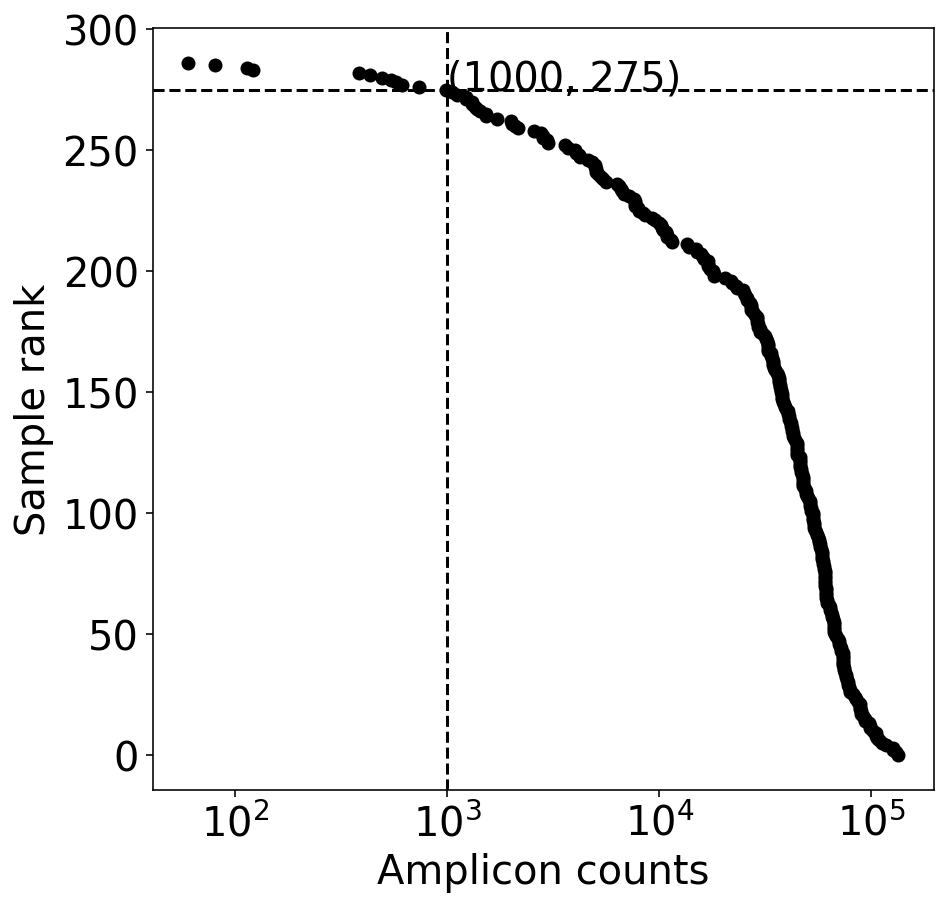

In [16]:
#@title Count distribution
fig, ax = plt.subplots(figsize=(7,7))

filter_counts = 1000
eps = 0.01

x = np.sort(nd(ndata.X[:,0:2].sum(axis=1)))[::-1] # only S and S spike
y = np.arange(len(x))
yidx = np.where(x<filter_counts)[0][0]
xx, yy = (filter_counts, y[yidx])

ax.axvline(x=xx, color="k", linestyle="--")
ax.axhline(y=yy, color="k", linestyle="--")

ax.scatter(x, y, color='k')


ax.annotate(f"({xx}, {yy})", (xx+eps, yy+eps))

ax.set(**{'xscale': 'symlog',
          'xlabel': 'Amplicon counts',
          'ylabel': 'Sample rank',
          })

plt.show()

# Enumerating all possibilities for barcode swapping

```
Let a barcode be either an index or index2 barcode then each barcode is associated with 

(Sample, Side, Amplicon) --> [S count, Spike count, Rpp30 count[]

Sample is an element from {1..N}
Side is an element from {1, 2} where 1 = left, 2 = right
Amplicon is an element from {1, 2} where 1 = S/spike amplicon, 2 = R amplicon
Note the amplicon is the amplicon associated with the barcode
```

In [18]:
# Are the two sides truly UDI
np.unique(np.array(ss['index'].values.tolist() + ss['index2'].values.tolist())).shape == ss.shape[0]*2

False

# The right way

In [19]:
ss['R_bcs'] = ss.Sample_ID.str.contains("-2")

In [106]:
mtx = adata.X.todense().astype(int)
index = adata.obs['index'].values
index2 = adata.obs['index2'].values

In [120]:
 # Remove the barcodes that are not UDI
all_bcs = ss['index'].values.tolist() +  ss['index2'].values.tolist()
bad = np.intersect1d(ss['index'].values, ss['index2'].values)
# bcs = np.setdiff1d(all_bcs, bad)
bad = np.unique(ss[np.logical_or(ss["index"].isin(bad), ss["index2"].isin(bad))]["index"].values.tolist() + ss[np.logical_or(ss["index"].isin(bad), ss["index2"].isin(bad))]["index2"].values.tolist())

In [121]:
bad

array(['AATCCGATGG', 'CACAGGATCG', 'CTCGCTTGAG', 'CTGAGTTACG',
       'GACTGACATG', 'GCTAGCCTCT'], dtype='<U10')

In [122]:
cleanss = ss[np.logical_or(~ss["index"].isin(bad), ~ss["index2"].isin(bad))]

In [123]:
cleanss.shape, ss.shape

((572, 17), (576, 17))

In [124]:
left = pd.DataFrame(np.vstack((cleanss[["index", "R_bcs"]].values, cleanss[["index2", "R_bcs"]].values)), columns=["bcs", "r_bcs"])
right = pd.DataFrame(np.vstack((cleanss[["index2", "R_bcs"]].values, cleanss[["index", "R_bcs"]].values)), columns=["bcs", "r_bcs"])

In [143]:
fwd_mask = [True]*len(cleanss)
rvs_mask = [False]*len(cleanss)
dir_mask = np.array(fwd_mask + rvs_mask)

isr_mask = cleanss.R_bcs.values.astype(bool)

In [162]:
cleanss.head()

,Plate_ID,virus_identity,lysate,virus_copy,bc_set,Plate_384,Plate_384_quadrant,MasterMixVol,RT,SpikeCopies,RPP_strategy,Sample_Well,Sample_ID,index,index2,bcs,R_bcs
bcs,,,,,,,,,,,,,,,,,
GTGAGTCTGTGCACTCAATT,Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-1,GTGAGTCTGT,GCACTCAATT,GTGAGTCTGTGCACTCAATT,False
TCACCGCAACCCATGGTGAA,Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-2,TCACCGCAAC,CCATGGTGAA,TCACCGCAACCCATGGTGAA,True
CAGCATTGCACTTCTAGCAT,Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-1,CAGCATTGCA,CTTCTAGCAT,CAGCATTGCACTTCTAGCAT,False
TATGACAGCCATGCGTACAA,Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-2,TATGACAGCC,ATGCGTACAA,TATGACAGCCATGCGTACAA,True
GTTACATCGGCGTTATCTCA,Plate1,U0069,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A03,Plate1-A03-1,GTTACATCGG,CGTTATCTCA,GTTACATCGGCGTTATCTCA,False


In [125]:
conf = np.zeros((2, left.shape[0], right.shape[0])).astype(int)

n_obs = mtx.shape[0]

for idx, (i1, i2, row) in enumerate(zip(index, index2, mtx)):
  if idx%10000==0:
    print(f'{idx:,.0f} of {n_obs:,.0f}')
    
  s_cnt, s_spike_cnt, n_cnt, n_spike_cnt, rpp30_cnt = nd(row).astype(int)

  if i1 not in bad and i2 not in bad:
    lidx = np.where(left == i1)[0][0]
    ridx = np.where(right == i2)[0][0]


    conf[0, lidx, ridx] += s_cnt+s_spike_cnt
    conf[1, lidx, ridx] += rpp30_cnt

0 of 107,051
10,000 of 107,051
20,000 of 107,051
30,000 of 107,051
40,000 of 107,051
50,000 of 107,051
60,000 of 107,051
70,000 of 107,051
80,000 of 107,051
90,000 of 107,051
100,000 of 107,051


In [126]:
np.where(bcs=="CAGCATTGCA"), np.where(bcs=="CTTCTAGCAT")

((array([2]),), (array([576]),))

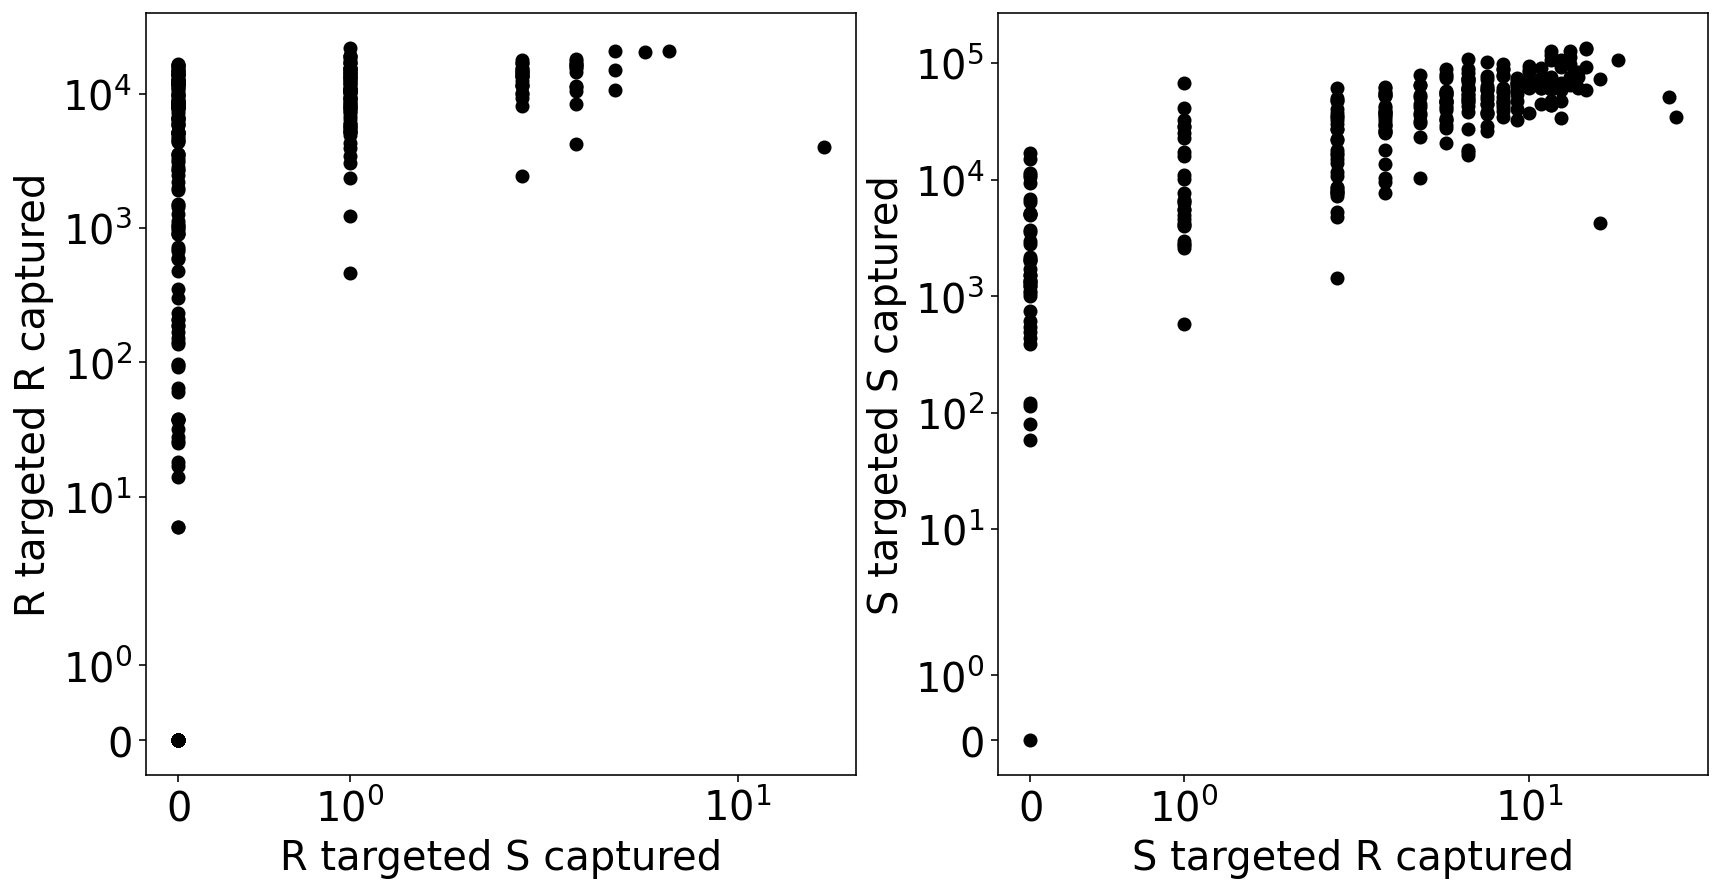

In [264]:
fig, ax = plt.subplots(figsize=(14,7), ncols=2)

x = np.diag(conf[0])[dir_mask][isr_mask]
y = np.diag(conf[1])[dir_mask][isr_mask]

ax[0].scatter(x, y, color="k")

kwd = {
    "yscale":"symlog",
    "xscale":"symlog",
    "xlabel": "R targeted S captured",
    "ylabel": "R targeted R captured"
}
ax[0].set(**kwd)
#############################
x = np.diag(conf[1])[dir_mask][~isr_mask]
y = np.diag(conf[0])[dir_mask][~isr_mask]

ax[1].scatter(x, y, color="k")

kwd = {
    "yscale":"symlog",
    "xscale":"symlog",
    "xlabel": "S targeted R captured",
    "ylabel": "S targeted S captured"
}
ax[1].set(**kwd)

fig.show()

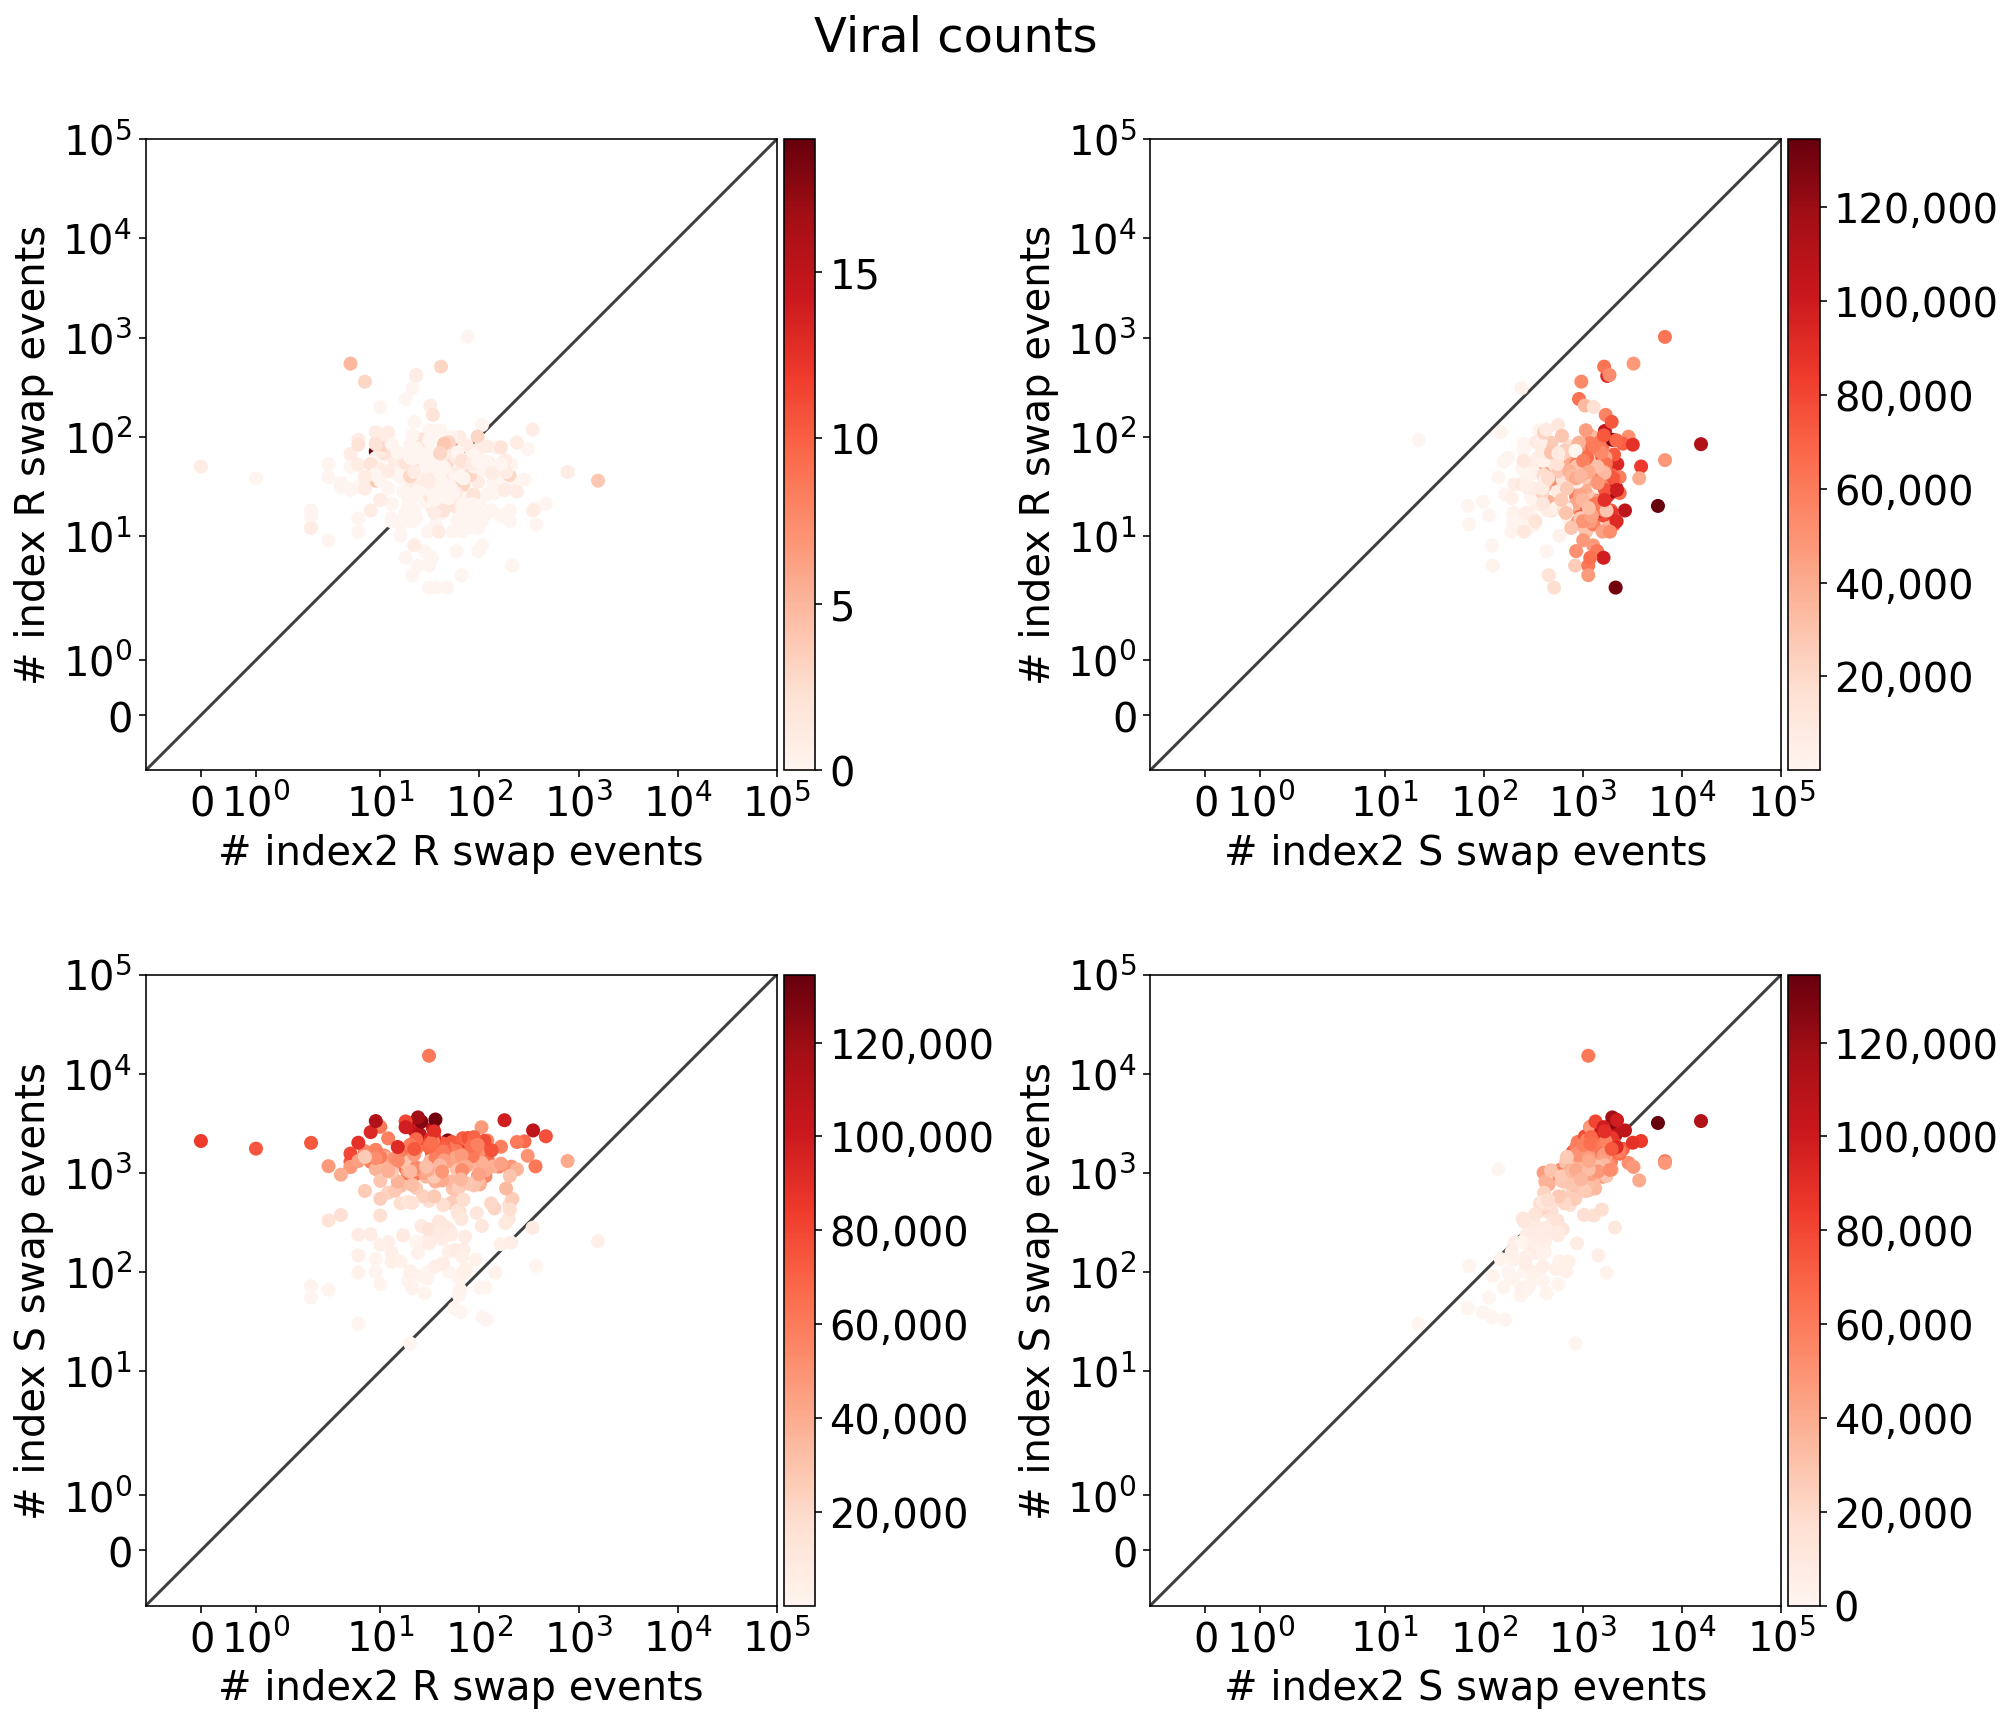

In [262]:
def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt))
  return

diag = np.diag(conf[0])[dir_mask]

off_0 = conf[0].sum(axis=0)[dir_mask] - diag
off_1 = conf[0].sum(axis=1)[dir_mask] - diag


#######
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0.05, wspace=0.5)

fig.suptitle("Viral counts", y=0.9)

kwd = {
    "xscale": "symlog",
    "yscale": "symlog",
    "xlim": (-1, 1e5),
    "ylim": (-1, 1e5),
    "xlabel": "# index2 R swap events",
    "ylabel": "# index R swap events"
}

###
loc = ax[0,0]
well_total = diag[isr_mask]

x = off_0[isr_mask] # _0 is index2
y = off_1[isr_mask] # _1 is index

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

loc.set(**kwd)
yex(loc)
cbar(sc, loc)

##################
loc = ax[0, 1]

well_total = diag[~isr_mask] + diag[isr_mask]

x = off_0[~isr_mask]
y = off_1[isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index R swap events"
    })

loc.set(**kwd)

yex(loc)
cbar(sc, loc)

#################
loc = ax[1, 0]

well_total = diag[isr_mask] + diag[~isr_mask]
x = off_0[isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")
kwd.update({
    "xlabel": "# index2 R swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

###############
loc = ax[1, 1]

well_total = diag[~isr_mask]

x = off_0[~isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

fig.show()

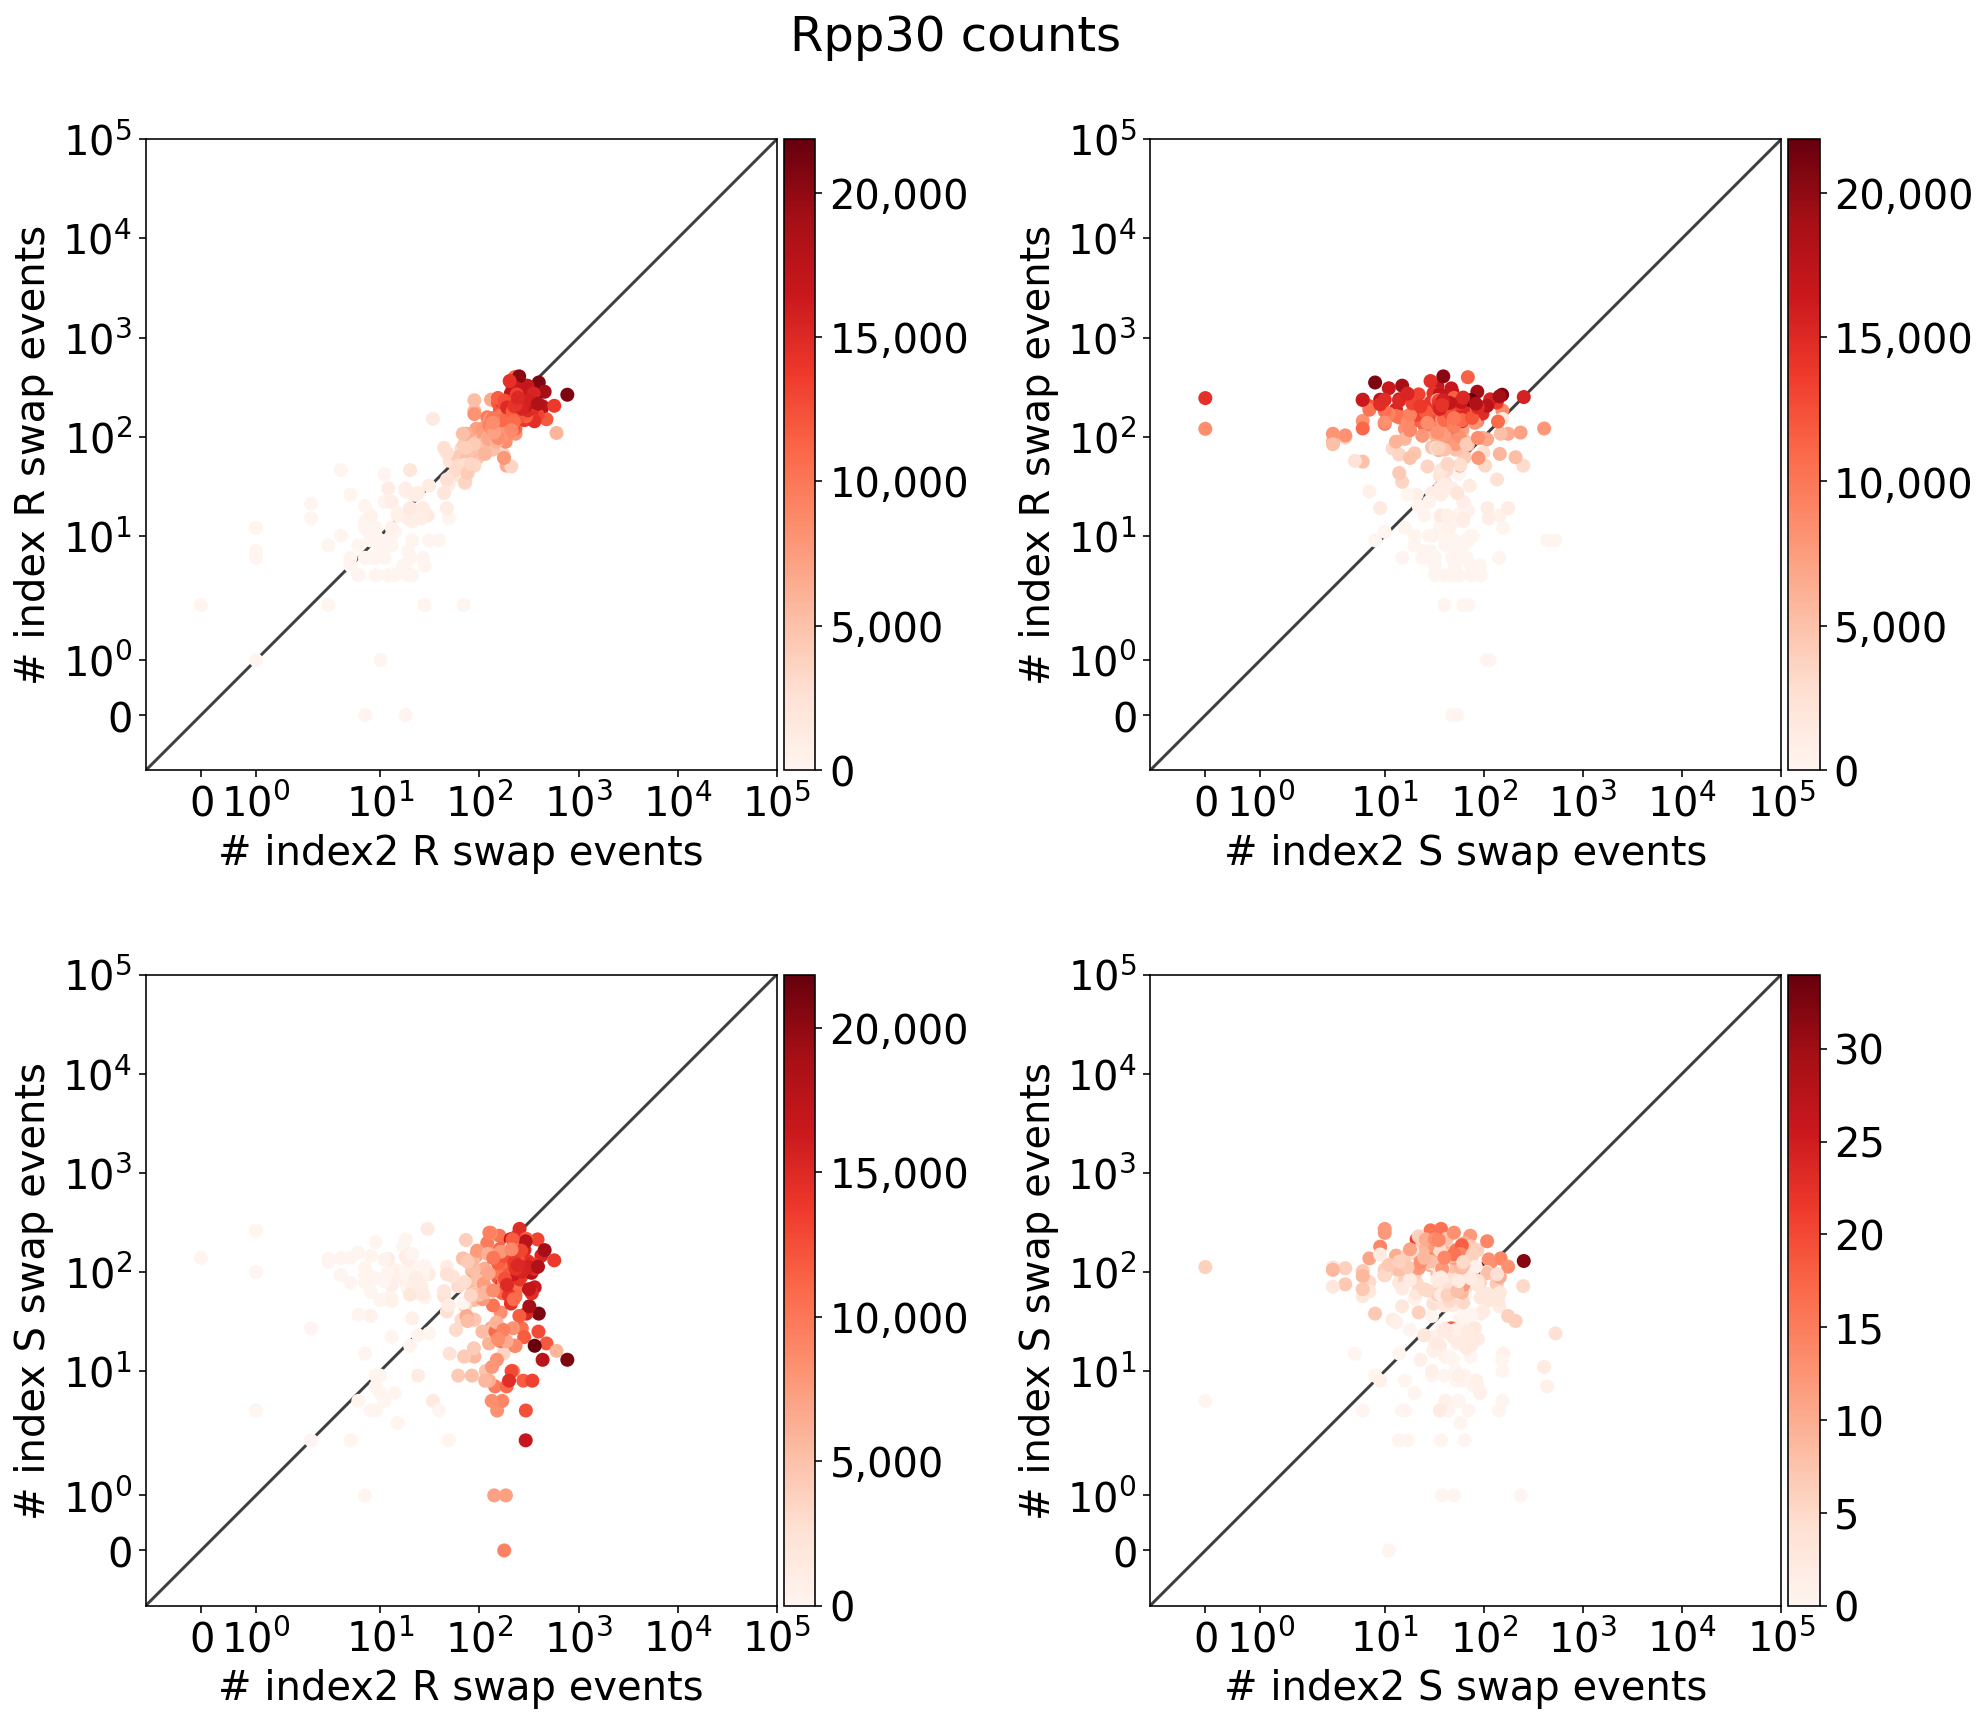

In [261]:
def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt))
  return

diag = np.diag(conf[1])[dir_mask]

off_0 = conf[1].sum(axis=0)[dir_mask] - diag
off_1 = conf[1].sum(axis=1)[dir_mask] - diag


#######
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0.05, wspace=0.5)

fig.suptitle("Rpp30 counts", y=0.9)

kwd = {
    "xscale": "symlog",
    "yscale": "symlog",
    "xlim": (-1, 1e5),
    "ylim": (-1, 1e5),
    "xlabel": "# index2 R swap events",
    "ylabel": "# index R swap events"
}

###
loc = ax[0,0]
well_total = diag[isr_mask]

x = off_0[isr_mask] # _0 is index2
y = off_1[isr_mask] # _1 is index

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

loc.set(**kwd)
yex(loc)
cbar(sc, loc)

##################
loc = ax[0, 1]

well_total = diag[~isr_mask] + diag[isr_mask]

x = off_0[~isr_mask]
y = off_1[isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index R swap events"
    })

loc.set(**kwd)

yex(loc)
cbar(sc, loc)

#################
loc = ax[1, 0]

well_total = diag[isr_mask] + diag[~isr_mask]
x = off_0[isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")
kwd.update({
    "xlabel": "# index2 R swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

###############
loc = ax[1, 1]

well_total = diag[~isr_mask]

x = off_0[~isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

fig.show()

________________________________________________________________________________________________________________________________________

In [239]:
left_s  = ss.query('R_bcs==False')['index'].values
right_s = ss.query('R_bcs==False')['index2'].values

left_r  = ss.query('R_bcs==True')['index'].values
right_r = ss.query('R_bcs==True')['index2'].values

mtx = adata.X.todense().astype(int)
index = adata.obs['index'].values
index2 = adata.obs['index2'].values

print(ss["index"].nunique() == ss.shape[0])
print(ss["index2"].nunique() == ss.shape[0])

True
True


In [242]:
conf.shape

(288, 288, 2, 2, 2)

In [240]:
conf = np.zeros((len(left_s), len(right_s), 2, 2, 2)).astype(int)

n_obs = mtx.shape[0]

for idx, (i1, i2, row) in enumerate(zip(index, index2, mtx)):
  if idx%10000==0:
    print(f'{idx:,.0f} of {n_obs:,.0f}')
  s_cnt, s_spike_cnt, n_cnt, n_spike_cnt, rpp30_cnt = nd(row).astype(int)
  # i1 is in either left_s or left_r
  lidx = np.where(left_s == i1)[0]
  tl = 0
  if len(lidx)==0:
    lidx = np.where(left_r == i1)[0]
    tl = 1
    if len(lidx) == 0:
      print("left error")

  ridx = np.where(right_s == i2)[0]
  tr = 0
  if len(ridx)==0:
    ridx = np.where(right_r==i2)[0]
    tr = 1
    if len(ridx)==0:
      print("right error")

  conf[lidx, ridx, tl, tr] = np.array([[s_cnt+s_spike_cnt, rpp30_cnt]])

0 of 107,051
10,000 of 107,051
20,000 of 107,051
30,000 of 107,051
40,000 of 107,051
50,000 of 107,051
60,000 of 107,051
70,000 of 107,051
80,000 of 107,051
90,000 of 107,051
100,000 of 107,051


correctly paired
check diagnoal elements between R and S, legit guy should be high either in one or the other. 
for every barcode pair you get a whole lot of ratios, look at distribution
nx2 matrix
(legit, nonlegit)

matrix should have no off diagnoal elements
look at off diagnoal, if you are in the Smatrix, look at which combinations, have labeled the left and right guys based off of R vs S targets

case where barcodes are incorrectly paired
break down error into 8 numbers
one row for s, one for r
R (SS, SR, RS, RR)
S (SS, SR, RS, RR)

have distributions

In [356]:
conf[0,1]

array([[[2, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]]])

In [247]:
conf[0, 0][1,1,1]

19044

In [72]:
conf[lidx, ridx, tl, tr]

array([[0., 1.]])

In [60]:
conf

matrix([[0, 0, 0, 0, 1]])

In [24]:
left = ndata.obs.index.values
right = ndata.obs.index2.values
bs = adata[np.logical_or(adata.obs.index.isin(left),  adata.obs.index2.isin(right))]
bad_bcs = bs.obs.index.values.astype(str)

In [25]:
bs

View of AnnData object with n_obs × n_vars = 74496 × 5
    obs: 'Plate_ID', 'virus_identity', 'lysate', 'virus_copy', 'bc_set', 'Plate_384', 'Plate_384_quadrant', 'MasterMixVol', 'RT', 'SpikeCopies', 'RPP_strategy', 'Sample_Well', 'Sample_ID', 'index', 'index2', 'bcs'

In [26]:
mtx = []
adata.obs.groupby(["Plate_ID", "Sample_Well"]).apply(lambda x: mtx.append(nd(adata.X[np.squeeze([np.where(bad_bcs == i)[0] for i in x.index.values] ) ].sum(axis=0))))


ValueError: ignored

# Barcode Swapping

In [17]:
#@title Generate confusion matrix
mtx = adata.X.todense().astype(int)


tmp = pd.DataFrame({'i1':left, 'i2': right, 's2':nd(mtx[:,0:2].sum(axis=1))}).groupby(['i1', 'i2'])['s2'].sum().to_dict()

conf = np.zeros((samples.shape[0], samples.shape[0]))

for idx, i in enumerate(index):
  for jdx, j in enumerate(index2):
    val = tmp.get((i, j), 0)
    conf[idx, jdx] = val

In [18]:
conf = conf.astype(int)

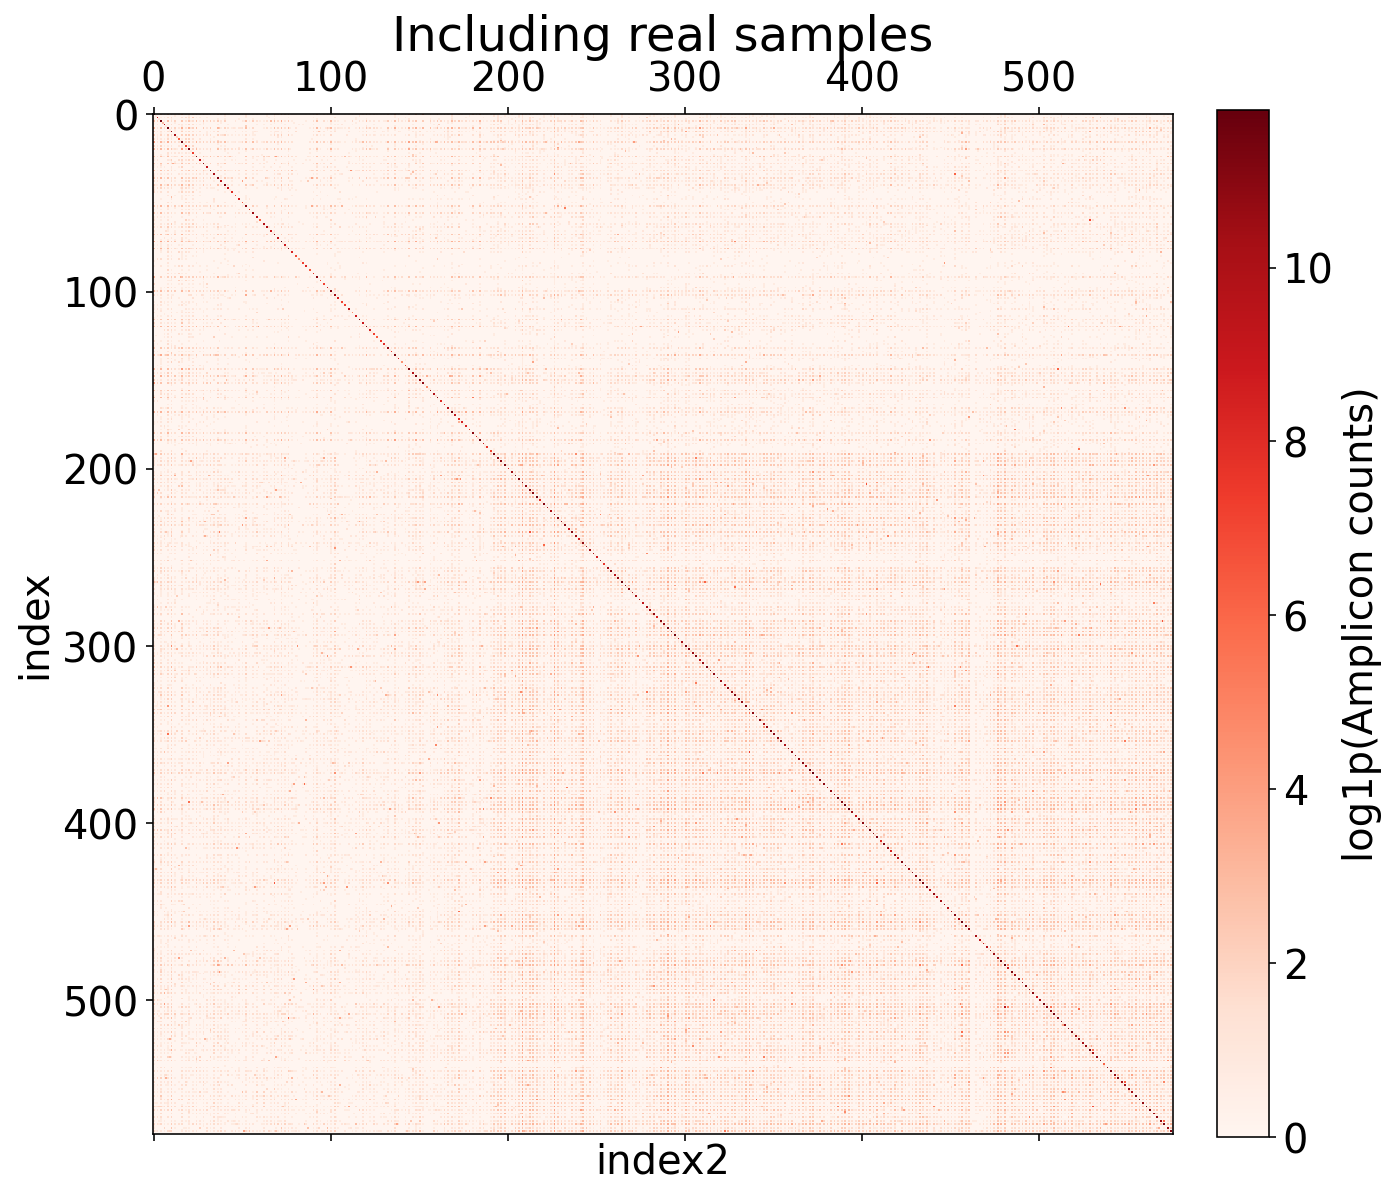

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.matshow(np.log1p(conf), cmap='Reds')
plt.colorbar(im,fraction=0.046, pad=0.04, label='log1p(Amplicon counts)')

ax.set(**{'xlabel':"index2",
          "ylabel":"index",
          "title": "Including real samples"})

plt.show()

In [20]:
norm = conf.copy()
np.fill_diagonal(norm, 0)

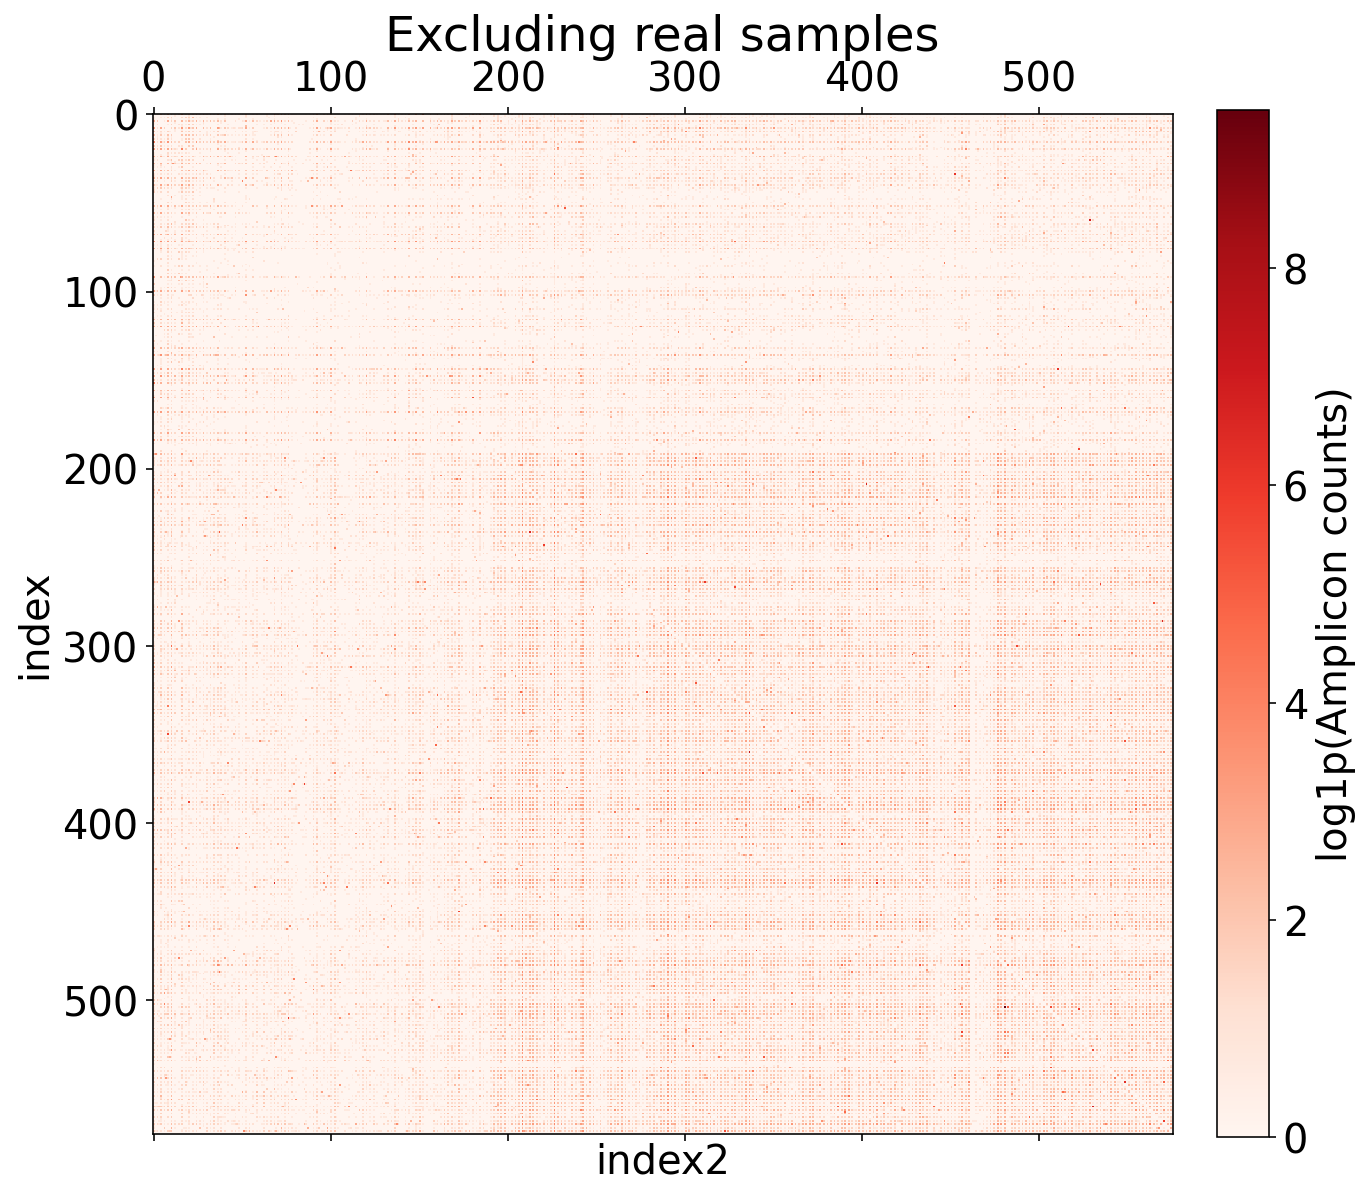

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.matshow(np.log1p(norm), cmap='Reds')
plt.colorbar(im,fraction=0.046, pad=0.04, label='log1p(Amplicon counts)')
ax.set(**{'xlabel':"index2",
          "ylabel":"index",
          "title": "Excluding real samples"})


plt.show()

In [22]:
print(norm.max())
print(np.argmax(norm))

12760
290784


In [23]:
i1, i2 = norm.max(axis=1).argmax(), norm.max(axis=0).argmax()

In [24]:
index[i1], index2[i2]

('TGTCTGACTG', 'ACGGTCCTAT')

# Quantifying the swapping effect

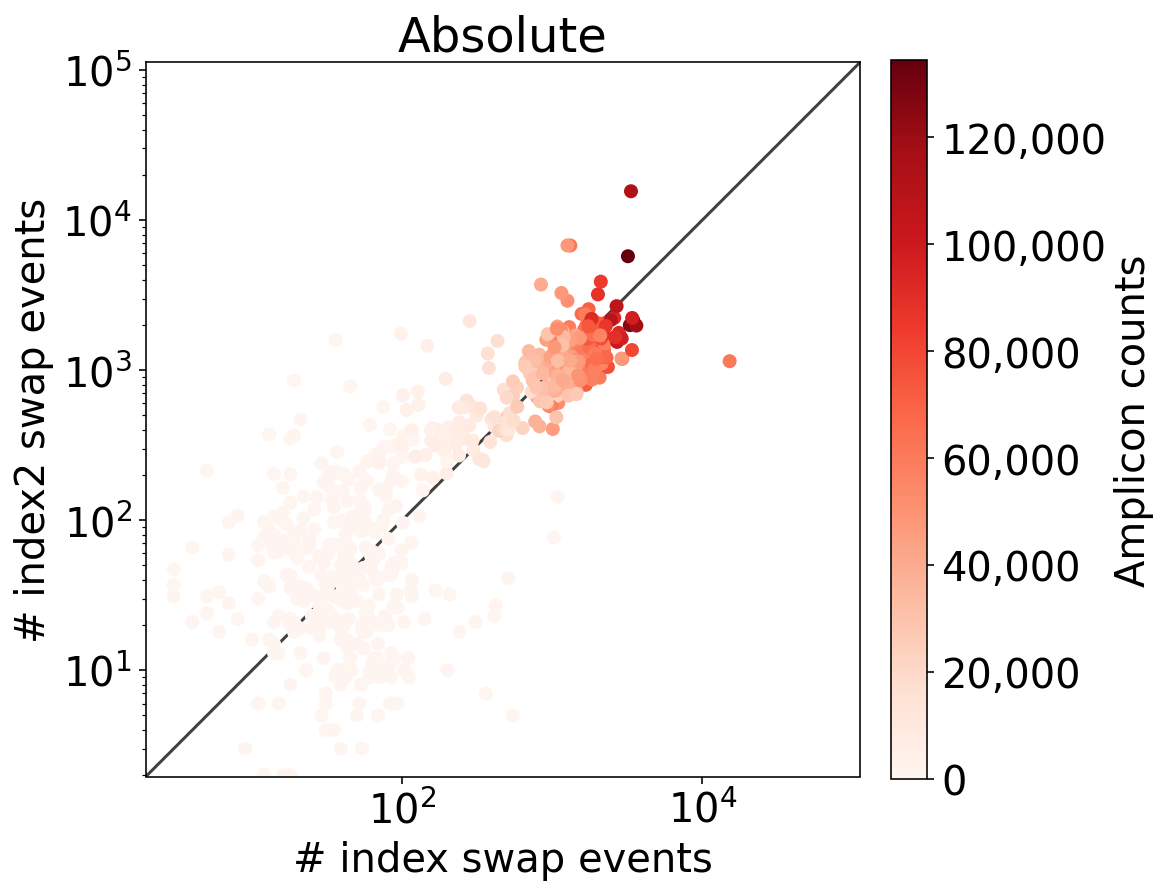

In [25]:
fig, ax = plt.subplots(figsize=(7,7))

x = norm.sum(axis=1) # index
y = norm.sum(axis=0) # index2

c = conf.diagonal()

im = ax.scatter(x, y, c=c, cmap="Reds")
ax.set(**{'xscale':'log',
          'yscale':'log',
          'xlabel': "# index swap events",
          "ylabel": "# index2 swap events",
          "title": "Absolute",
          })

plt.colorbar(im,fraction=0.046, pad=0.04, format=mpl.ticker.StrMethodFormatter('{x:,.0f}'), label="Amplicon counts")

yex(ax)

plt.show()

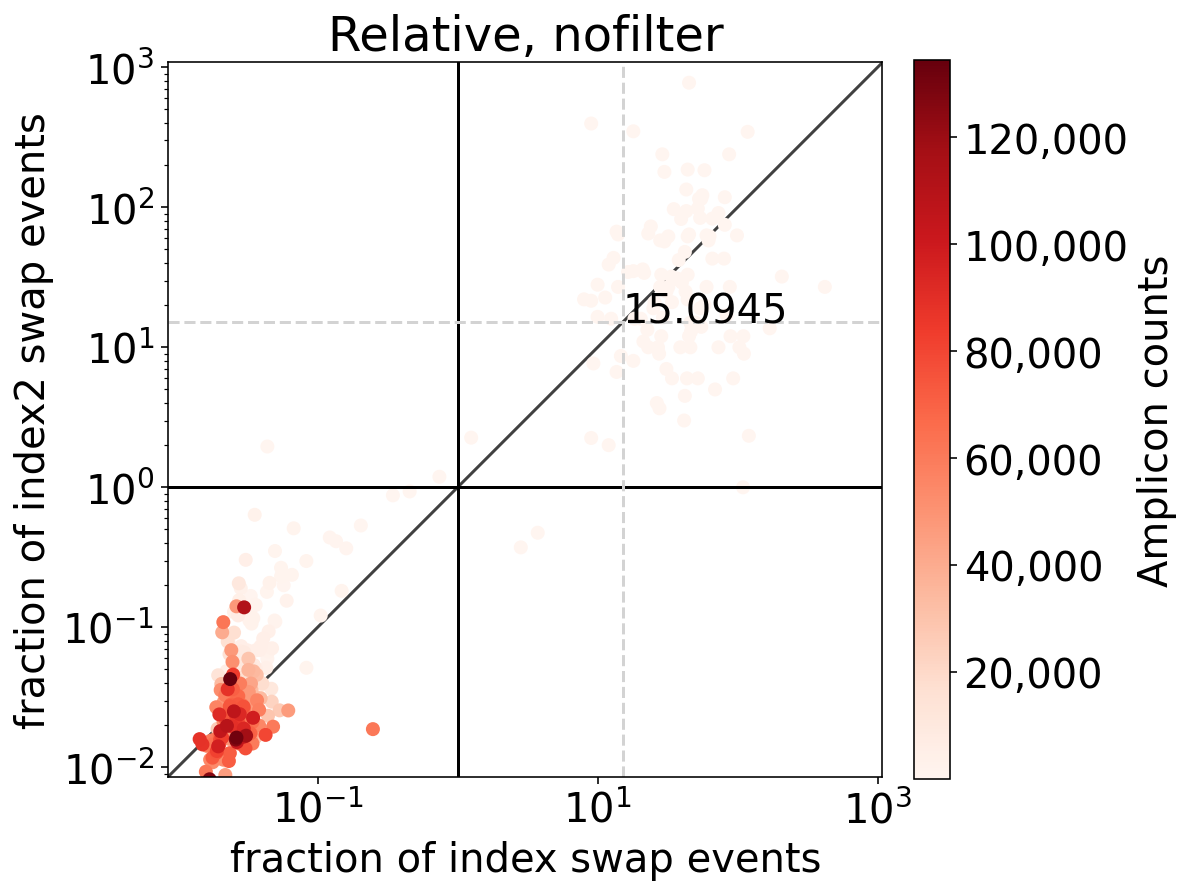

In [26]:
fig, ax = plt.subplots(figsize=(7,7))

mask = conf.diagonal()>0
c = conf.diagonal()[mask]

argsort = np.argsort(c)

x = norm.sum(axis=1)[mask]/(c) # index
y = norm.sum(axis=0)[mask]/(c) # index2

x = x[argsort]
y = y[argsort]
c = c[argsort]


ax.axvline(x=1, color="black")
ax.axhline(y=1, color="black")


mean = np.mean([x, y], axis=1).mean()
ax.axvline(x=mean, linestyle="--", color="lightgrey")
ax.axhline(y=mean, linestyle="--", color="lightgrey")
ax.annotate(f"{mean:,.4f}", (mean, mean))

im = ax.scatter(x, y, c=c, cmap="Reds")


ax.set(**{'xscale':'log',
          'yscale':'log',
          'xlabel': "fraction of index swap events",
          "ylabel": "fraction of index2 swap events",
          "title": "Relative, nofilter",
          })
plt.colorbar(im,fraction=0.046, pad=0.04, format=mpl.ticker.StrMethodFormatter('{x:,.0f}'), label="Amplicon counts")


yex(ax)

plt.show()

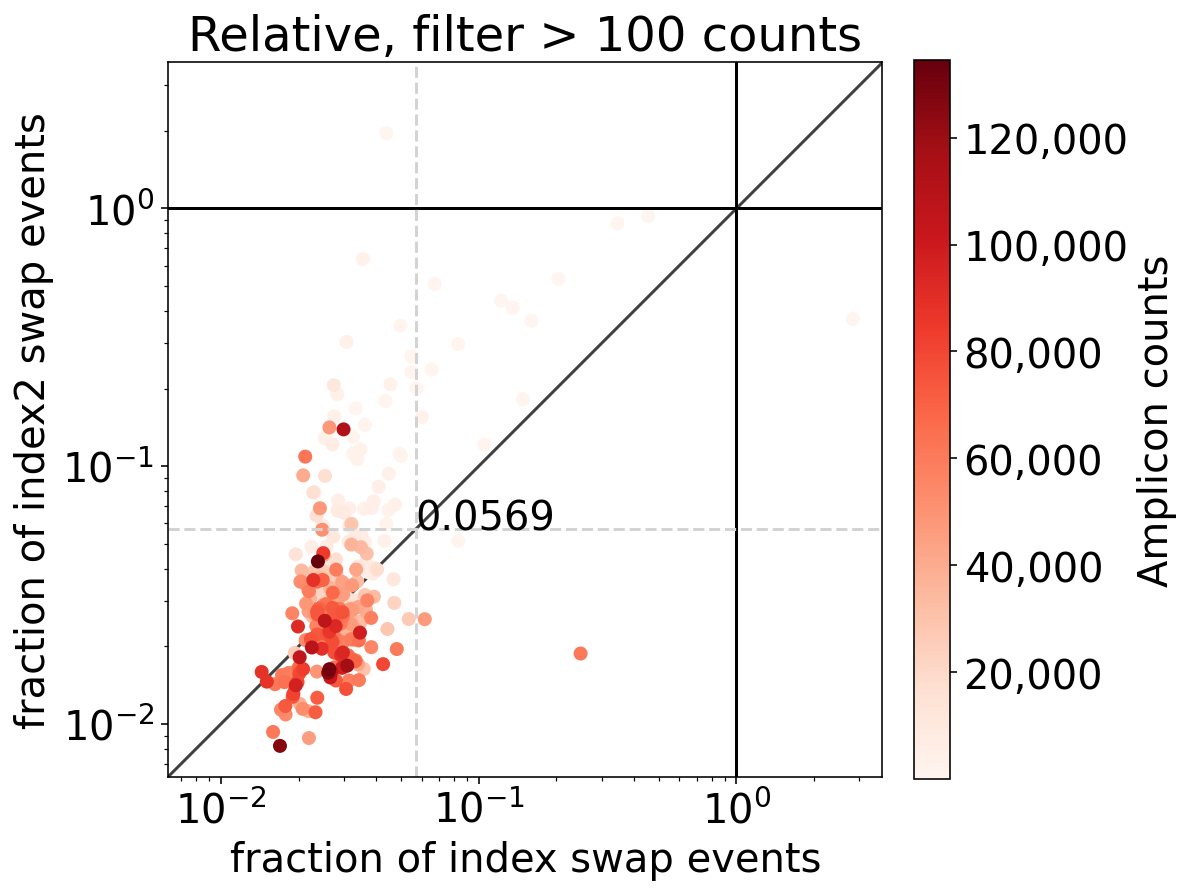

In [27]:
fig, ax = plt.subplots(figsize=(7,7))

n = 100
mask = conf.diagonal()>n
c = conf.diagonal()[mask]

argsort = np.argsort(c)

x = norm.sum(axis=1)[mask]/(c) # index
y = norm.sum(axis=0)[mask]/(c) # index2

x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.axvline(x=1, color="black")
ax.axhline(y=1, color="black")


mean = np.mean([x, y], axis=1).mean()
ax.axvline(x=mean, linestyle="--", color="lightgrey")
ax.axhline(y=mean, linestyle="--", color="lightgrey")
ax.annotate(f"{mean:,.4f}", (mean, mean))

im = ax.scatter(x, y, c=c, cmap="Reds")

ax.set(**{'xscale':'log',
          'yscale':'log',
          'xlabel': "fraction of index swap events",
          "ylabel": "fraction of index2 swap events",
          "title": f"Relative, filter > {n} counts",
          })
          
plt.colorbar(im,fraction=0.046, pad=0.04, format=mpl.ticker.StrMethodFormatter('{x:,.0f}'), label="Amplicon counts")


yex(ax)

plt.show()

# Looking at the the wells where virus_copy is 0

In [28]:
data

View of AnnData object with n_obs × n_vars = 543 × 5
    obs: 'Plate_ID', 'virus_identity', 'lysate', 'virus_copy', 'bc_set', 'Plate_384', 'Plate_384_quadrant', 'MasterMixVol', 'RT', 'SpikeCopies', 'RPP_strategy', 'Sample_Well', 'Sample_ID', 'index', 'index2', 'bcs'

In [29]:
data.X[data.obs.eval("virus_copy == '0'").values].todense()[:,0]

matrix([[14.],
        [19.],
        [ 8.],
        [ 5.],
        [35.],
        [22.],
        [ 0.],
        [40.],
        [10.],
        [13.],
        [10.],
        [ 8.],
        [19.],
        [ 3.],
        [ 0.],
        [ 8.]], dtype=float32)

In [30]:
s_spike = nd(data.X[data.obs.eval("virus_copy == '0'").values][:,1].todense()).astype(int)
s = nd(data.X[data.obs.eval("virus_copy == '0'").values][:,0].todense()).astype(int)

In [31]:
data.X[data.obs.eval("virus_copy == '0'").values].todense().astype(int)

matrix([[    14,  60843,      0,      0,     10],
        [    19,  46818,      0,      0,      2],
        [     8,  42473,      0,      0,      5],
        [     5,  51381,      0,      0,      4],
        [    35, 131509,      0,      0,     16],
        [    22,  61500,      0,      0,     11],
        [     0,      0,      0,      0,      6],
        [    40, 134426,      0,      0,     16],
        [    10,  20461,      0,      0,      5],
        [    13,  78034,      0,      0,      7],
        [    10,  41924,      0,      0,      4],
        [     8,  25956,      0,      0,      3],
        [    19,  58626,      0,      0,     13],
        [     3,  15088,      0,      0,      0],
        [     0,      0,      0,      0,     98],
        [     8,  28269,      0,      0,      1]])

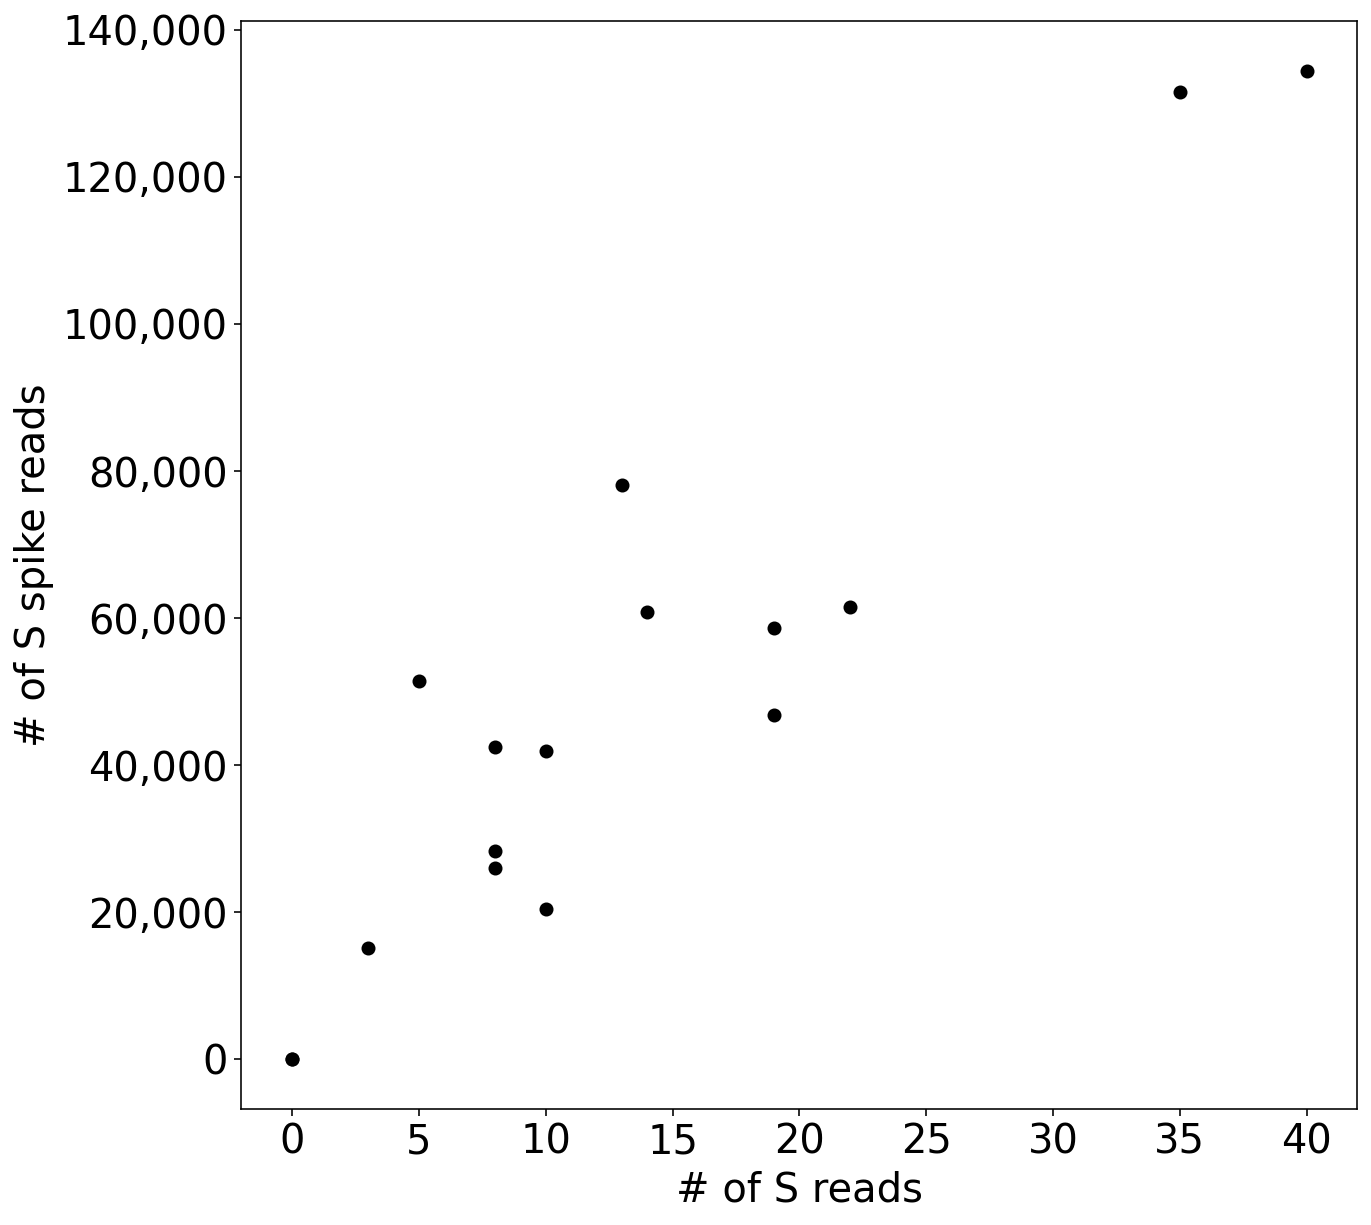

In [32]:
fix, ax = plt.subplots(figsize=(10,10))

x = s
y = s_spike

ax.scatter(x, y, color="k")

kwd = {
    "xlabel": "# of S reads",
    "ylabel": "# of S spike reads"
}

ax.set(**kwd)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [55]:
x = data.X[data.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].todense().astype(int)[:,0]
y = data.X[data.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].todense().astype(int)[:,1]

In [72]:
data.obs.query("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'")[nd(data.X[data.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values][:,-1].todense()>1000)]

,Plate_ID,virus_identity,lysate,virus_copy,bc_set,Plate_384,Plate_384_quadrant,MasterMixVol,RT,SpikeCopies,RPP_strategy,Sample_Well,Sample_ID,index,index2,bcs
barcode,,,,,,,,,,,,,,,,
AACATTCGCAATAACGAGAC,Plate14,N3864,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,F03,Plate14-F03-2,AACATTCGCA,ATAACGAGAC,AACATTCGCAATAACGAGAC
AACCTTCTTGCTGTGTTCAA,Plate14,N3850,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,H01,Plate14-H01-2,AACCTTCTTG,CTGTGTTCAA,AACCTTCTTGCTGTGTTCAA
AAGGCAATACCGAACTGAAT,Plate14,N3865,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,G03,Plate14-G03-2,AAGGCAATAC,CGAACTGAAT,AAGGCAATACCGAACTGAAT
AAGGTGTTAGACGGACAGTA,Plate14,N3922,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,H10,Plate14-H10-2,AAGGTGTTAG,ACGGACAGTA,AAGGTGTTAGACGGACAGTA
AAGTAGCTAGGTAGTAGTAC,Plate14,N3883,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,A06,Plate14-A06-2,AAGTAGCTAG,GTAGTAGTAC,AAGTAGCTAGGTAGTAGTAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAGGCTTGTATTACGCCAC,Plate14,N3902,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,D08,Plate14-D08-2,TTAGGCTTGT,ATTACGCCAC,TTAGGCTTGTATTACGCCAC
TTCACGCACGATTCCTTGGT,Plate14,N3932,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,B12,Plate14-B12-2,TTCACGCACG,ATTCCTTGGT,TTCACGCACGATTCCTTGGT
TTCATCTTCGATCGAGAAGA,Plate14,N3859,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,A03,Plate14-A03-2,TTCATCTTCG,ATCGAGAAGA,TTCATCTTCGATCGAGAAGA


In [71]:
data.obs.query("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'")[nd(data.X[data.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values][:,0].todense()>0)]

,Plate_ID,virus_identity,lysate,virus_copy,bc_set,Plate_384,Plate_384_quadrant,MasterMixVol,RT,SpikeCopies,RPP_strategy,Sample_Well,Sample_ID,index,index2,bcs
barcode,,,,,,,,,,,,,,,,
AACACTGCTTCCACCATCAA,Plate14,N3917,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,C10,Plate14-C10-1,AACACTGCTT,CCACCATCAA,AACACTGCTTCCACCATCAA
AACATTCGCAATAACGAGAC,Plate14,N3864,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,F03,Plate14-F03-2,AACATTCGCA,ATAACGAGAC,AACATTCGCAATAACGAGAC
AAGGCAACCGCTCACCGACT,Plate14,N3869,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,C04,Plate14-C04-1,AAGGCAACCG,CTCACCGACT,AAGGCAACCGCTCACCGACT
AAGTACGAGTTTGGACAACG,Plate14,N3919,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,E10,Plate14-E10-1,AAGTACGAGT,TTGGACAACG,AAGTACGAGTTTGGACAACG
AATGAAGCGACTACTGTTGT,Plate14,N3864,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,F03,Plate14-F03-1,AATGAAGCGA,CTACTGTTGT,AATGAAGCGACTACTGTTGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTACCTCGTATGAAGAGCTT,Plate14,N3900,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,B08,Plate14-B08-1,TTACCTCGTA,TGAAGAGCTT,TTACCTCGTATGAAGAGCTT
TTAGACATGCGGCTAATCCT,Plate14,N3907,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,A09,Plate14-A09-1,TTAGACATGC,GGCTAATCCT,TTAGACATGCGGCTAATCCT
TTAGGAACCGTCTACATGCT,Plate14,N3892,NP swab into VTM,Negative Patient,N1_S2_RPP30,1.0,2.0,20uL,taqpath,500.0,50.0,B07,Plate14-B07-1,TTAGGAACCG,TCTACATGCT,TTAGGAACCGTCTACATGCT


In [59]:
data.X[data.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14' and virus_identity != 'TE'").values].todense().astype(int)

matrix([[    23,  28946,      0,      0,      7],
        [     2,      0,      0,      0,  14058],
        [     0,      0,      0,      0,   5841],
        [     0,      0,      0,      0,    922],
        [     1,   7978,      0,      0,      2],
        [     0,      0,      0,      0,   9996],
        [     0,      0,      0,      0,   8723],
        [     3,   8400,      0,      0,      2],
        [     0,      0,      0,      0,   8110],
        [     0,      1,      0,      0,  11688],
        [     0,      0,      0,      0,   3089],
        [     0,      0,      0,      0,    963],
        [     0,      0,      0,      0,  13795],
        [    26,  86497,      0,      0,     10],
        [     0,      0,      0,      0,   1005],
        [     0,      0,      0,      0,   1968],
        [    16,  66604,      0,      0,      9],
        [     8,  34474,      0,      0,      8],
        [     2,  11386,      0,      0,      0],
        [    24,  59863,      0,      0,      6],


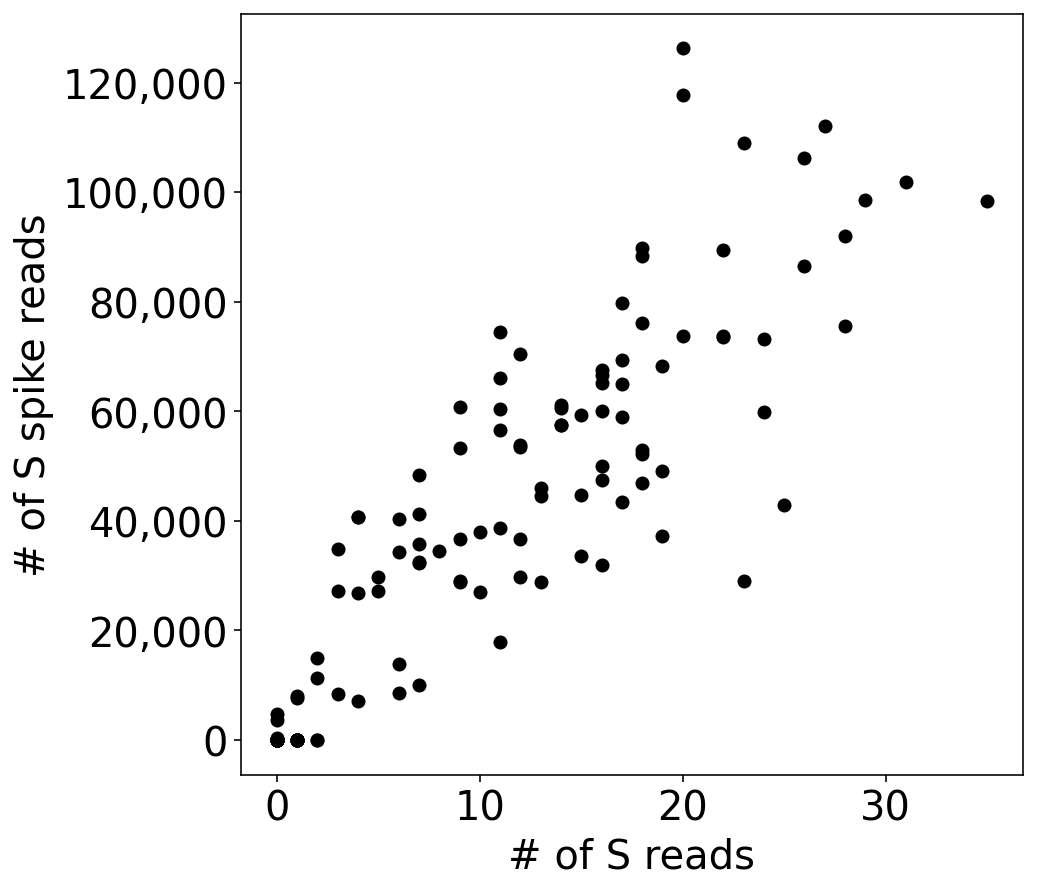

In [56]:
fig, ax = plt.subplots(figsize=(7,7))

x = nd(x)
y = nd(y)


ax.scatter(x, y, color="k")

kwd = {
    "xlabel": "# of S reads",
    "ylabel": "# of S spike reads"
}

ax.set(**kwd)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [33]:
m = nd(data.X[data.obs.eval('virus_copy=="0"').values].todense()[:,np.logical_or(data.var.index.values=='N1', data.var.index.values=='S2')].sum(axis=1))>0
worst_idx = np.argmax(data[data.obs.eval('virus_copy=="0"')][m].X.todense().astype(int)[:,0])
data[data.obs.eval('virus_copy=="0"')][m].obs.iloc[worst_idx]

Plate_ID                           Plate11
virus_identity                          TE
lysate                    NP swab into VTM
virus_copy                               0
bc_set                         N1_S2_RPP30
Plate_384                                1
Plate_384_quadrant                       3
MasterMixVol                          20uL
RT                                 taqpath
SpikeCopies                            500
RPP_strategy                            50
Sample_Well                            G01
Sample_ID                    Plate11-G01-1
index                           GCCGCAATTC
index2                          AACCATGCAA
bcs                   GCCGCAATTCAACCATGCAA
Name: GCCGCAATTCAACCATGCAA, dtype: object

In [34]:
bcs = data[data.obs.eval('virus_copy=="0"')][m].obs.iloc[worst_idx].bcs

In [35]:
data[data.obs.eval(f'bcs=="{bcs}"')].X.todense().astype(int)

matrix([[    40, 134426,      0,      0,     16]])